In [41]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
import pandas as pd
import xarray as xr
from bayes_opt import BayesianOptimization
from bayes_opt import UtilityFunction
import time
import seaborn as sns
from itertools import product
from scipy.interpolate import interp2d

#ML
from sklearn.gaussian_process import GaussianProcessRegressor 

In [42]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
'''CLM CASE'''
from clmmodtools import *

#setup case
CASE_NAME = 'testing_bayesopt_nobuild'
setup_mef_case('/glade/u/home/marielj/clm_frost/cesm_cases/bayesopt', CASE_NAME, MODS = True, nyears = 1)
CASE_DIR = '/glade/u/home/marielj/clm_frost/cesm_cases/bayesopt/testing_bayesopt_nobuild'

## 1D Parameter Tuning

In [ ]:
#start with single parameter variation [SLATOP]
def blackbox_clm(x):
    #change parameter in netcdf file
    target_param_file = '/glade/work/marielj/inputdata/lnd/clm2/paramdata/clm5_params_augmented_base.c171117.nc'
    target_param = 'slatop'
    pft = 12 #arctic grass 
    
    change_pft_param(target_param, pft, x, target_param_file)
    
    os.chdir(CASE_DIR)
    
    #run case
    pipe = subprocess.Popen(['qcmd', '-- ./case.submit'], stdout=subprocess.PIPE)
    #result = pipe.communicate()[0]
    #print(result)
    #print(CASE_NAME + " Run Complete")
    
    #time delay -- check if archived data exists, if not wait 5 more seconds
    SCRATCH_DIR = '/glade/scratch/marielj/archive/' + CASE_NAME + '/lnd/hist/'
    while(not os.path.exists(SCRATCH_DIR + CASE_NAME + '.clm2.h1.2011-01-01-00000.nc')):
        time.sleep(5)
    
    #find WTE data in scracth directory
    os.chdir(SCRATCH_DIR)
    
    #Open data h1 data file
    dat = xr.load_dataset(CASE_NAME + '.clm2.h1.2011-01-01-00000.nc')
    mean_wtd = -np.mean(dat.ZWT.values)
    #remove data
    os.remove(CASE_NAME + '.clm2.h1.2011-01-01-00000.nc')
    
    #mean_wte = np.double(416.000) - mean_wtd
    
    #return average annual WTE
    return mean_wtd

In [43]:
def posterior(optimizer, x_obs, y_obs, grid):
    optimizer._gp.fit(x_obs, y_obs)

    mu, sigma = optimizer._gp.predict(grid, return_std=True)
    return mu, sigma

In [44]:
def plot_gp_adapted(optimizer, x, param):
    fig = plt.figure(figsize=(8, 5))
    steps = len(optimizer.space)
    fig.suptitle(
        'Gaussian Process and Utility Function After {} Steps'.format(steps),
        fontdict={'size':30}
    )
    
    #Setup grid
    gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1]) 
    axis = plt.subplot(gs[0])
    acq = plt.subplot(gs[1])
    
    #Observation points 
    x_obs = np.array([[res["params"][param]] for res in optimizer.res])
    y_obs = np.array([res["target"] for res in optimizer.res])
    
    #Interpolate the confidence interval using skilearn
    mu, sigma = posterior(optimizer, x_obs, y_obs, x)
    axis.plot(x_obs.flatten(), y_obs, 'D', markersize=8, label=u'Observations', color='r')
    axis.plot(x, mu, '--', color='k', label='Prediction')

    #Plot the Confidence interval using error from posterior simulation
    axis.fill(np.concatenate([x, x[::-1]]), 
              np.concatenate([mu - 1.9600 * sigma, (mu + 1.9600 * sigma)[::-1]]),
        alpha=.6, fc='c', ec='None', label='95% confidence interval')
    
    axis.set_ylim((None, None))
    axis.set_ylabel('Water Table Depth', fontdict={'size':20})
    axis.set_xlabel(param, fontdict={'size':20})
    
    utility_function = UtilityFunction(kind="ucb", kappa = 0.1)
    utility = utility_function.utility(x, optimizer._gp, 0)
    acq.plot(x, utility, label='Utility Function', color='purple')
    acq.plot(x[np.argmax(utility)], np.max(utility), '*', markersize=15, 
             label=u'Next Best Guess', markerfacecolor='gold', markeredgecolor='k', markeredgewidth=1)
    #acq.set_ylim((0, np.max(utility) + 0.5))
    acq.set_ylabel('Utility', fontdict={'size':20})
    acq.set_xlabel(param, fontdict={'size':20})
    
    axis.legend(loc=2, bbox_to_anchor=(1.01, 1), borderaxespad=0.)
    acq.legend(loc=2, bbox_to_anchor=(1.01, 1), borderaxespad=0.)
    
    plt.savefig('/glade/u/home/marielj/clm_frost/cesm_cases/bayesopt/figures/bayesopt_' + param + '_1d_probing.pdf')

### Probing 1D - SLATOP

In [ ]:
#Declare optimizer
clm_optimizer = BayesianOptimization(blackbox_clm, 
                                    {'x': (0.004, 0.4)}, 
                                    random_state = 45729, 
                                    )
#Aquisition function
acquisition_function = UtilityFunction(kind="ucb", kappa=10)

In [ ]:
for p in np.linspace(0.004, 0.4, 10):
    clm_optimizer.probe(
        params={"x": p},
        lazy=True,
    )

clm_optimizer.maximize(init_points = 0, n_iter = 0)

In [ ]:
x_slatop = np.linspace(0.004, 0.4, 100).reshape(-1, 1)
plot_gp_adapted(clm_optimizer, x_slatop, 'slatop')

In [ ]:
#Optimize an additional 5 steps from the initial probing
clm_optimizer.maximize(init_points = 0, n_iter = 5, aquisition_function = acquisition_function)

In [ ]:
#Plot
plot_gp_adapted(clm_optimizer, x_slatop, 'slatop')

### Probing 1D - FROOTLEAF

In [ ]:
#Set slatop param back to default value
change_pft_param('slatop', 12, 0.04024, '/glade/work/marielj/inputdata/lnd/clm2/paramdata/clm5_params_augmented_base.c171117.nc')

In [ ]:
def blackbox_clm2(x):
    #change parameter in netcdf file
    target_param_file = '/glade/work/marielj/inputdata/lnd/clm2/paramdata/clm5_params_augmented_base.c171117.nc'
    target_param = 'froot_leaf'
    pft = 12 #arctic grass 
    
    change_pft_param(target_param, pft, x, target_param_file)
    
    os.chdir(CASE_DIR)
    
    #run case
    pipe = subprocess.Popen(['qcmd', '-- ./case.submit'], stdout=subprocess.PIPE)
    #result = pipe.communicate()[0]
    #print(result)
    #print(CASE_NAME + " Run Complete")
    
    #time delay -- check if archived data exists, if not wait 5 more seconds
    SCRATCH_DIR = '/glade/scratch/marielj/archive/' + CASE_NAME + '/lnd/hist/'
    while(not os.path.exists(SCRATCH_DIR + CASE_NAME + '.clm2.h1.2011-01-01-00000.nc')):
        time.sleep(5)
    
    #find WTE data in scracth directory
    os.chdir(SCRATCH_DIR)
    
    #Open data h1 data file
    dat = xr.load_dataset(CASE_NAME + '.clm2.h1.2011-01-01-00000.nc')
    mean_wtd = -np.mean(dat.ZWT.values)
    #remove data
    os.remove(CASE_NAME + '.clm2.h1.2011-01-01-00000.nc')
    
    #mean_wte = np.double(416.000) - mean_wtd
    
    #return average annual WTE
    return mean_wtd

In [ ]:
#Declare optimizer
clm_optimizer_froot = BayesianOptimization(blackbox_clm2, 
                                    {'x': (0.015, 2.0)}, 
                                    random_state = 491929, 
                                    )
#Aquisition function
acquisition_function_froot = UtilityFunction(kind="ucb", kappa=10)

In [ ]:
#Probe
for p in np.linspace(0.015, 2.0, 10):
    clm_optimizer_froot.probe(
        params={"x": p},
        lazy=True,
    )

clm_optimizer_froot.maximize(init_points = 0, n_iter = 0)

In [ ]:
x_frootleaf = np.linspace(0.015, 2.0, 100).reshape(-1, 1)
plot_gp_adapted(clm_optimizer_froot, x_frootleaf, 'frootleaf')

### Probing 1D - leaf_long

In [ ]:
#Set slatop param back to default value
change_pft_param('leaf_long', 12, 0.32083, '/glade/work/marielj/inputdata/lnd/clm2/paramdata/clm5_params_augmented_base.c171117.nc')

In [ ]:
def blackbox_clm3(x):
    #change parameter in netcdf file
    target_param_file = '/glade/work/marielj/inputdata/lnd/clm2/paramdata/clm5_params_augmented_base.c171117.nc'
    target_param = 'leaf_long'
    pft = 12 #arctic grass 
    
    change_pft_param(target_param, pft, x, target_param_file)
    
    os.chdir(CASE_DIR)
    
    #run case
    pipe = subprocess.Popen(['qcmd', '-- ./case.submit'], stdout=subprocess.PIPE)
    #result = pipe.communicate()[0]
    #print(result)
    #print(CASE_NAME + " Run Complete")
    
    #time delay -- check if archived data exists, if not wait 5 more seconds
    SCRATCH_DIR = '/glade/scratch/marielj/archive/' + CASE_NAME + '/lnd/hist/'
    while(not os.path.exists(SCRATCH_DIR + CASE_NAME + '.clm2.h1.2011-01-01-00000.nc')):
        time.sleep(5)
    
    #find WTE data in scracth directory
    os.chdir(SCRATCH_DIR)
    
    #Open data h1 data file
    dat = xr.load_dataset(CASE_NAME + '.clm2.h1.2011-01-01-00000.nc')
    mean_wtd = -np.mean(dat.ZWT.values)
    #remove data
    os.remove(CASE_NAME + '.clm2.h1.2011-01-01-00000.nc')
    
    #mean_wte = np.double(416.000) - mean_wtd
    
    #return average annual WTE
    return mean_wtd

In [ ]:
#Declare optimizer
clm_optimizer_leaflong = BayesianOptimization(blackbox_clm3, 
                                    {'x': (0.30, 2.0)}, 
                                    random_state = 48193, 
                                    )
#Aquisition function
acquisition_function_leaflong = UtilityFunction(kind="ucb", kappa=10)

In [ ]:
#Probe
for p in np.linspace(0.30, 2.0, 10):
    clm_optimizer_leaflong.probe(
        params={"x": p},
        lazy=True,
    )

clm_optimizer_leaflong.maximize(init_points = 0, n_iter = 0)

In [ ]:
x_leaflong = np.linspace(0.30, 2.0, 10).reshape(-1, 1)
plot_gp_adapted(clm_optimizer_leaflong, x_leaflong, 'leaflong')

### Probing 1D - fover (fff)

In [ ]:
#Set slatop param back to default value
change_pft_param('leaf_long', 12, 0.32083, '/glade/work/marielj/inputdata/lnd/clm2/paramdata/clm5_params_augmented_base.c171117.nc')

In [ ]:
def blackbox_clm4(x):
    #change parameter in netcdf file
    target_param_file = '/glade/work/marielj/inputdata/lnd/clm2/paramdata/clm5_params_augmented_base.c171117.nc'
    target_param = 'fff'
    pft = 12 #arctic grass 
    
    change_param(target_param, x, target_param_file)
    
    os.chdir(CASE_DIR)
    
    #run case
    pipe = subprocess.Popen(['qcmd', '-- ./case.submit'], stdout=subprocess.PIPE)
    #result = pipe.communicate()[0]
    #print(result)
    #print(CASE_NAME + " Run Complete")
    
    #time delay -- check if archived data exists, if not wait 5 more seconds
    SCRATCH_DIR = '/glade/scratch/marielj/archive/' + CASE_NAME + '/lnd/hist/'
    while(not os.path.exists(SCRATCH_DIR + CASE_NAME + '.clm2.h1.2011-01-01-00000.nc')):
        time.sleep(5)
    
    #find WTE data in scracth directory
    os.chdir(SCRATCH_DIR)
    
    #Open data h1 data file
    dat = xr.load_dataset(CASE_NAME + '.clm2.h1.2011-01-01-00000.nc')
    mean_wtd = -np.mean(dat.ZWT.values)
    #remove data
    os.remove(CASE_NAME + '.clm2.h1.2011-01-01-00000.nc')
    
    #mean_wte = np.double(416.000) - mean_wtd
    
    #return average annual WTE
    return mean_wtd

In [ ]:
#Declare optimizer
clm_optimizer_fff = BayesianOptimization(blackbox_clm4, 
                                    {'x': (0.1, 5.0)}, 
                                    random_state = 858392, 
                                    )
#Aquisition function
acquisition_function_fff = UtilityFunction(kind="ucb", kappa=10)

In [ ]:
#Probe
for p in np.linspace(0.1, 5.0, 10):
    clm_optimizer_fff.probe(
        params={"x": p},
        lazy=True,
    )

clm_optimizer_fff.maximize(init_points = 0, n_iter = 0)

In [ ]:
x_fff = np.linspace(0.1, 5.0, 100).reshape(-1, 1)
plot_gp_adapted(clm_optimizer_fff, x_fff, 'fover')

### Probing 1D - slopebeta

In [ ]:
#Set fover param back to default value
change_param('fff', 0.5, '/glade/work/marielj/inputdata/lnd/clm2/paramdata/clm5_params_augmented_base.c171117.nc')

In [ ]:
def blackbox_clm5(x):
    #change parameter in netcdf file
    target_param_file = '/glade/work/marielj/inputdata/lnd/clm2/paramdata/clm5_params_augmented_base.c171117.nc'
    target_param = 'slopebeta'
    pft = 12 #arctic grass 
    
    change_param(target_param, x, target_param_file)
    
    os.chdir(CASE_DIR)
    
    #run case
    pipe = subprocess.Popen(['qcmd', '-- ./case.submit'], stdout=subprocess.PIPE)
    #result = pipe.communicate()[0]
    #print(result)
    #print(CASE_NAME + " Run Complete")
    
    #time delay -- check if archived data exists, if not wait 5 more seconds
    SCRATCH_DIR = '/glade/scratch/marielj/archive/' + CASE_NAME + '/lnd/hist/'
    while(not os.path.exists(SCRATCH_DIR + CASE_NAME + '.clm2.h1.2011-01-01-00000.nc')):
        time.sleep(5)
    
    #find WTE data in scracth directory
    os.chdir(SCRATCH_DIR)
    
    #Open data h1 data file
    dat = xr.load_dataset(CASE_NAME + '.clm2.h1.2011-01-01-00000.nc')
    mean_wtd = -np.mean(dat.ZWT.values)
    #remove data
    os.remove(CASE_NAME + '.clm2.h1.2011-01-01-00000.nc')
    
    #mean_wte = np.double(416.000) - mean_wtd
    
    #return average annual WTE
    return mean_wtd

In [ ]:
#Declare optimizer
clm_optimizer_slopebeta = BayesianOptimization(blackbox_clm5, 
                                    {'x': (-1000, 10)}, 
                                    random_state = 589320, 
                                    )
#Aquisition function
acquisition_function_slopebeta = UtilityFunction(kind="ucb", kappa=10)

In [ ]:
#Probe
for p in np.linspace(-1000, 10, 10):
    clm_optimizer_slopebeta.probe(
        params={"x": p},
        lazy=True,
    )

clm_optimizer_slopebeta.maximize(init_points = 0, n_iter = 0)

In [ ]:
x_slopebeta = np.linspace(-1000, 10, 100).reshape(-1, 1)
plot_gp_adapted(clm_optimizer_slopebeta, x_slopebeta, 'slopebeta')

In [ ]:
#Set slopebeta param back to default value
change_param('slopebeta', 3, '/glade/work/marielj/inputdata/lnd/clm2/paramdata/clm5_params_augmented_base.c171117.nc')

## 2D Parameter Tuning

In [ ]:
#setup case
CASE_NAME = 'testing_bayesopt_nobuild_2D'
setup_mef_case('/glade/u/home/marielj/clm_frost/cesm_cases/bayesopt', CASE_NAME, MODS = True, nyears = 1)
CASE_DIR = '/glade/u/home/marielj/clm_frost/cesm_cases/bayesopt/testing_bayesopt_nobuild_2D'

In [ ]:
def blackbox_clm2D(slopebeta, fff):
    #change parameter in netcdf file
    target_param_file = '/glade/work/marielj/inputdata/lnd/clm2/paramdata/clm5_params_augmented_base.c171117.nc'
    target_param1 = 'slopebeta'
    target_param2 = 'fff'
    pft = 12 #arctic grass  
    
    #change slopebeta
    change_param(target_param1, slopebeta, target_param_file)
    #change fover
    change_param(target_param2, fff, target_param_file)
    
    os.chdir(CASE_DIR)
    
    #run case
    pipe = subprocess.Popen(['qcmd', '-- ./case.submit'], stdout=subprocess.PIPE)
    #result = pipe.communicate()[0]
    #print(result)
    #print(CASE_NAME + " Run Complete")
    
    #time delay -- check if archived data exists, if not wait 5 more seconds
    SCRATCH_DIR = '/glade/scratch/marielj/archive/' + CASE_NAME + '/lnd/hist/'
    while(not os.path.exists(SCRATCH_DIR + CASE_NAME + '.clm2.h1.2011-01-01-00000.nc')):
        time.sleep(5)
    
    #find WTE data in scracth directory
    os.chdir(SCRATCH_DIR)
    
    #Open data h1 data file
    dat = xr.load_dataset(CASE_NAME + '.clm2.h1.2011-01-01-00000.nc')
    mean_wtd = -np.mean(dat.ZWT.values)
    #remove data
    os.remove(CASE_NAME + '.clm2.h1.2011-01-01-00000.nc')
    
    #return average annual WTE
    return mean_wtd

In [ ]:
#Declare optimizer
clm_optimizer2D = BayesianOptimization(f = blackbox_clm2D, 
                                    pbounds = {'slopebeta': (-1000, 10), 'fff': (0.1, 5)}, 
                                    random_state = 4889, 
                                    verbose = 0
                                    )
#Aquisition function
acquisition_function2D = UtilityFunction(kind="ucb", kappa=10000)

#Optimize
clm_optimizer2D.maximize(init_points = 0, n_iter = 5, aquisition_function = acquisition_function2D, allow_duplicate_points=True)

## Plot Iterations

In [ ]:
def plot_gp_2D(optimizer, aq, it, param1, param2, param1_min, param1_max, param2_min, param2_max):
    #Setup 
    #Breakdown Data
    max_ = optimizer.max
    res = optimizer.res[:it]
    x_ = np.array([r["params"][param1] for r in res])
    y_ = np.array([r["params"][param2] for r in res])
    z_ = np.array([r["target"] for r in res])

    #Model Results
    ser = pd.Series(z_,
                      index=[y_, x_])
    Z = ser.unstack().fillna(np.nan)

    #Range space
    x1 = np.linspace(param1_min, param1_max, 100).reshape(-1, 1)
    x2 = np.linspace(param2_min, param2_max, 100).reshape(-1, 1)
    xmesh, ymesh = np.meshgrid(x1, x2)
    xy = np.array(list(zip(xmesh.reshape(10000, 1), ymesh.reshape(10000, 1)))).reshape(10000,2)

    #Utility Function
    util = aq.utility(xy, optimizer._gp, 0)
    
    #Plot
    fig, axs = plt.subplots(1, 2, constrained_layout=True, figsize=(12,6))

    #Axis 1: Function Estimate
    mesh1 = axs[0].pcolormesh(Z.columns, Z.index,  Z, cmap=plt.cm.coolwarm)
    axs[0].scatter(x_, y_, c='white', s=80, edgecolors='black')
    axs[0].scatter(x_, y_, c='red', s=80, edgecolors='black')
    axs[0].scatter(max_["params"][param1], max_["params"][param2], s=80, c='green', edgecolors='black')

    axs[0].set_title('Function Estimate')
    axs[0].set_xlabel(param1)
    axs[0].set_ylabel(param2)

    axs[0].set_xlim(param1_min, param1_max)
    axs[0].set_ylim(param2_min, param2_max)

    fig.colorbar(mesh1, location = 'bottom', label = "Predicted Average Annual WTD")

    #Axis 2: Utility Function
    util = acquisition_function2D.utility(xy, clm_optimizer2D._gp, 0)
    mesh2 = axs[1].pcolormesh(x1.reshape(100), x2.reshape(100), util.reshape(100,100), cmap = plt.cm.coolwarm)

    axs[1].scatter(x_, y_, c='white', s=80, edgecolors='black')
    axs[1].scatter(x_, y_, c='red', s=80, edgecolors='black')
    axs[1].scatter(max_["params"][param1], max_["params"][param2], s=80, c='green', edgecolors='black')

    axs[1].set_title('Utility Function')
    axs[1].set_xlabel(param1)
    axs[1].set_ylabel(param2)

    axs[1].set_xlim(param1_min, param1_max)
    axs[1].set_ylim(param2_min, param2_max)

    fig.colorbar(mesh2, location = 'bottom', label = "Upper Confidence Bound Acquisition Function") 
    plt.savefig('/glade/u/home/marielj/clm_frost/cesm_cases/bayesopt/figures/bayesopt_' + param1 + '_' + param2 + '_2d.pdf')

    plt.show()

In [ ]:
plot_gp_2D(clm_optimizer2D, acquisition_function2D, 5, 'slopebeta', 'fff', -1000, 10, 0.1, 5)

## Full Domain Probing

In [45]:
'''CLM CASE'''
from clmmodtools import *

#setup case
CASE_NAME = 'testing_bayesopt_nobuild_ND_7y'
setup_mef_case('/glade/u/home/marielj/clm_frost/cesm_cases/bayesopt', CASE_NAME, MODS = True, nyears = 7) #2011, 2012, 2013 - will grab the value from 01/01/2014
CASE_DIR = '/glade/u/home/marielj/clm_frost/cesm_cases/bayesopt/testing_bayesopt_nobuild_ND_7y'

Case already exists.


Parameters:

PFT (change_pft_param):
- 'SLATOP':[0.004, 0.04]
- 'LEAFLONG':[0.32, 2.0]
- 'FROOTLEAF':[0.015, 2.0]

Non-PFT (change_param):
- 'SLOPEBETA': [-1000, 10]
- 'FOVER': [0.1, 5]

Namelist:
- 'BASEFLOW': [10e-8, 2]
- 'FMAX' : [0.1, 0.7]

In [46]:
def blackbox_clmND(slatop, leaflong, frootleaf, slopebeta, fff, baseflow, fmax):
    #change parameter in netcdf file
    target_param_file = '/glade/work/marielj/inputdata/lnd/clm2/paramdata/clm5_params_augmented_base.c171117.nc'
    pft = 12 #arctic grass  
    
    #PFT Params
    change_pft_param('slatop', pft, slatop, target_param_file)
    change_pft_param('leaf_long', pft, leaflong, target_param_file)
    change_pft_param('froot_leaf', pft, frootleaf, target_param_file)
    
    #NON PFT Params
    change_param('slopebeta', slopebeta, target_param_file)
    change_param('fff', fff, target_param_file)    
    
    os.chdir(CASE_DIR)
    
    #Namelist Params
    change_nl_param('soil_fmax', fmax)
    change_nl_param('baseflow_scalar', baseflow)
    
    #run case
    pipe = subprocess.Popen(['qcmd', '-- ./case.submit'], stdout=subprocess.PIPE)
    #result = pipe.communicate()[0]
    #print(result)
    #print(CASE_NAME + " Run Complete")
    
    #time delay -- check if archived data exists, if not wait 5 more seconds
    SCRATCH_DIR = '/glade/scratch/marielj/archive/' + CASE_NAME + '/lnd/hist/'
    while(not os.path.exists(SCRATCH_DIR + CASE_NAME + '.clm2.h1.2018-01-01-00000.nc')):
        time.sleep(5)
    
    #find WTE data in scracth directory
    os.chdir(SCRATCH_DIR)
    
    #Open data h1 data file
    dat = xr.load_dataset(CASE_NAME + '.clm2.h1.2018-01-01-00000.nc')
    mean_wtd = -np.mean(dat.ZWT.values)
    #remove data
    os.remove(CASE_NAME + '.clm2.h1.2018-01-01-00000.nc')
    
    #return average annual WTE
    return mean_wtd

In [55]:
def blackbox_clm(slatop):
    #change parameter in netcdf file
    target_param_file = '/glade/work/marielj/inputdata/lnd/clm2/paramdata/clm5_params_augmented_base.c171117.nc'
    target_param = 'slatop'
    pft = 12 #arctic grass 
    
    #PFT Params
    change_pft_param('slatop', pft, slatop, target_param_file)
    change_pft_param('leaf_long', pft, 0.32, target_param_file)
    change_pft_param('froot_leaf', pft, 0, target_param_file)
    
    #NON PFT Params
    change_param('slopebeta', 0, target_param_file)
    change_param('fff', 0, target_param_file)    
    
    os.chdir(CASE_DIR)
    
    #Namelist Params
    change_nl_param('soil_fmax', 0)
    change_nl_param('baseflow_scalar', 0)
    
    os.chdir(CASE_DIR)
    
    #run case
    pipe = subprocess.Popen(['qcmd', '-- ./case.submit'], stdout=subprocess.PIPE)
    #result = pipe.communicate()[0]
    #print(result)
    #print(CASE_NAME + " Run Complete")
    
    #time delay -- check if archived data exists, if not wait 5 more seconds
    SCRATCH_DIR = '/glade/scratch/marielj/archive/' + CASE_NAME + '/lnd/hist/'
    while(not os.path.exists(SCRATCH_DIR + CASE_NAME + '.clm2.h1.2018-01-01-00000.nc')):
        time.sleep(5)
    
    #find WTE data in scratch directory
    os.chdir(SCRATCH_DIR)
    
    #Open data h1 data file
    dat = xr.load_dataset(CASE_NAME + '.clm2.h1.2018-01-01-00000.nc')
    mean_wtd = -np.mean(dat.ZWT.values)
    #remove data
    os.remove(CASE_NAME + '.clm2.h1.2018-01-01-00000.nc')
    
    #mean_wte = np.double(416.000) - mean_wtd
    
    #return average annual WTE
    return mean_wtd

In [49]:
#Declare optimizer
clm_optimizer = BayesianOptimization(f = blackbox_clmND, 
                                    pbounds = {'slatop': (0.004, 0.04), 
                                               'leaflong':(0.32, 2.0),
                                               'frootleaf':(0.015, 2.0),
                                               'slopebeta': (-1000, 10),
                                               'fff': (0.1, 5),
                                               'baseflow': (0, 10e-8),
                                               'fmax' : (0.1, 0.7)}, 
                                    random_state = 42829)

In [50]:
#Increased Kappa to increase searching
#Aquisition function
acquisition_functionND = UtilityFunction(kind="ucb", kappa=1000)

In [51]:
'''Probing'''
def probe_clm(slatop, leaflong, frootleaf, slopebeta, fff, baseflow, fmax):
    #Set up probe
    clm_optimizer.probe(
        params = {'slatop': slatop,
                  'leaflong': leaflong,
                  'frootleaf': frootleaf,
                  'slopebeta': slopebeta,
                  'fff': fff,
                  'baseflow': baseflow,
                  'fmax' : fmax},
        lazy=True,
    )
    
    #Run probe (& print)
    clm_optimizer.maximize(init_points = 0, n_iter = 0)

### Base

In [ ]:
probe_clm(slatop = 0, leaflong = 0, frootleaf = 0, slopebeta = 0, fff = 0, baseflow = 0, fmax = 0)

### slopebeta - 1D probing with fixed values

In [ ]:
#Declare optimizer
clm_optimizer1D = BayesianOptimization(f = blackbox_clm, 
                                    pbounds = {#'slatop': (0.004, 0.04), 
                                               #'leaflong':(0.32, 2.0),
                                               #'frootleaf':(0.015, 2.0),
                                               'slopebeta': (-500, 500)
                                               #'fff': (0.1, 5),
                                               #'baseflow': (0, 10e-8),
                                               #'fmax' : (0.1, 0.7)
                                    }, 
                                    random_state = 58239)

In [ ]:
#Probe
for p in np.linspace(-500, 500, 10):
    clm_optimizer1D.probe(
        params={"slopebeta": p},
        lazy=True,
    )

clm_optimizer1D.maximize(init_points = 0, n_iter = 0)

In [ ]:
plot_gp_adapted(clm_optimizer1D, np.linspace(-500, 500, 10).reshape(-1, 1), 'slopebeta')

### fover- 1D probing with fixed values

In [ ]:
#Declare optimizer
clm_optimizer1D = BayesianOptimization(f = blackbox_clm, 
                                    pbounds = {#'slatop': (0.004, 0.04), 
                                               #'leaflong':(0.32, 2.0),
                                               #'frootleaf':(0.015, 2.0),
                                               #'slopebeta': (-500, 500)
                                               'fff': (0, 5)
                                               #'baseflow': (0, 10e-8),
                                               #'fmax' : (0.1, 0.7)
                                    }, 
                                    random_state = 58239)

In [ ]:
#Probe
for p in np.linspace(0, 5, 10):
    clm_optimizer1D.probe(
        params={"fff": p},
        lazy=True,
    )

clm_optimizer1D.maximize(init_points = 0, n_iter = 0)

In [ ]:
plot_gp_adapted(clm_optimizer1D, np.linspace(0, 5, 10).reshape(-1, 1), 'fff')

### slatop - 1D probing with fixed values

In [57]:
#Declare optimizer
clm_optimizer1D = BayesianOptimization(f = blackbox_clm, 
                                    pbounds = {'slatop': (0, 0.04) 
                                               #'leaflong':(0.32, 2.0),
                                               #'frootleaf':(0.015, 2.0),
                                               #'slopebeta': (-500, 500)
                                               #'fff': (0, 5)
                                               #'baseflow': (0, 10e-8),
                                               #'fmax' : (0.1, 0.7)
                                    }, 
                                    random_state = 58239)

In [58]:
#Probe
for p in np.linspace(0, 0.04, 10):
    clm_optimizer1D.probe(
        params={"slatop": p},
        lazy=True,
    )

clm_optimizer1D.maximize(init_points = 0, n_iter = 0)

|   iter    |  target   |  slatop   |
-------------------------------------
| 1         | -0.4056   | 0.0       |


Traceback (most recent call last):
  File "/ncar/opt/sam/sam_validate.py", line 114, in <module>
    check_wallclock(db, user)
  File "/ncar/opt/sam/sam_validate.py", line 32, in check_wallclock
    print ("None")
IOError: [Errno 32] Broken pipe
Traceback (most recent call last):
  File "/ncar/opt/sam/sam_validate.py", line 114, in <module>
    check_wallclock(db, user)
  File "/ncar/opt/sam/sam_validate.py", line 32, in check_wallclock
    print ("None")
IOError: [Errno 32] Broken pipe


| 2         | -0.4056   | 0.004444  |


Traceback (most recent call last):
  File "/ncar/opt/sam/sam_validate.py", line 117, in <module>
    print_shadow_info(user)
  File "/ncar/opt/sam/sam_validate.py", line 80, in print_shadow_info
    time.localtime(time.time())),
IOError: [Errno 32] Broken pipe


| 3         | -0.4056   | 0.008889  |


Traceback (most recent call last):
  File "/ncar/opt/sam/sam_validate.py", line 114, in <module>
    check_wallclock(db, user)
  File "/ncar/opt/sam/sam_validate.py", line 32, in check_wallclock
    print ("None")
IOError: [Errno 32] Broken pipe


| 4         | -0.4056   | 0.01333   |


Traceback (most recent call last):
  File "/ncar/opt/sam/sam_validate.py", line 114, in <module>
    check_wallclock(db, user)
  File "/ncar/opt/sam/sam_validate.py", line 32, in check_wallclock
    print ("None")
IOError: [Errno 32] Broken pipe


| 5         | -0.4056   | 0.01778   |


Traceback (most recent call last):
  File "/ncar/opt/sam/sam_validate.py", line 117, in <module>
    print_shadow_info(user)
  File "/ncar/opt/sam/sam_validate.py", line 84, in print_shadow_info
    print("gecos: %s" % pw.pw_gecos)
IOError: [Errno 32] Broken pipe


| 6         | -0.4056   | 0.02222   |


Traceback (most recent call last):
  File "/ncar/opt/sam/sam_validate.py", line 114, in <module>
    check_wallclock(db, user)
  File "/ncar/opt/sam/sam_validate.py", line 32, in check_wallclock
    print ("None")
IOError: [Errno 32] Broken pipe


| 7         | -0.4056   | 0.02667   |


Traceback (most recent call last):
  File "/ncar/opt/sam/sam_validate.py", line 117, in <module>
    print_shadow_info(user)
  File "/ncar/opt/sam/sam_validate.py", line 80, in print_shadow_info
    time.localtime(time.time())),
IOError: [Errno 32] Broken pipe


| 8         | -0.4056   | 0.03111   |


Traceback (most recent call last):
  File "/ncar/opt/sam/sam_validate.py", line 117, in <module>
    print_shadow_info(user)
  File "/ncar/opt/sam/sam_validate.py", line 84, in print_shadow_info
    print("gecos: %s" % pw.pw_gecos)
IOError: [Errno 32] Broken pipe


| 9         | -0.4056   | 0.03556   |


Traceback (most recent call last):
  File "/ncar/opt/sam/sam_validate.py", line 117, in <module>
    print_shadow_info(user)
  File "/ncar/opt/sam/sam_validate.py", line 80, in print_shadow_info
    time.localtime(time.time())),
IOError: [Errno 32] Broken pipe


| 10        | -0.4056   | 0.04      |


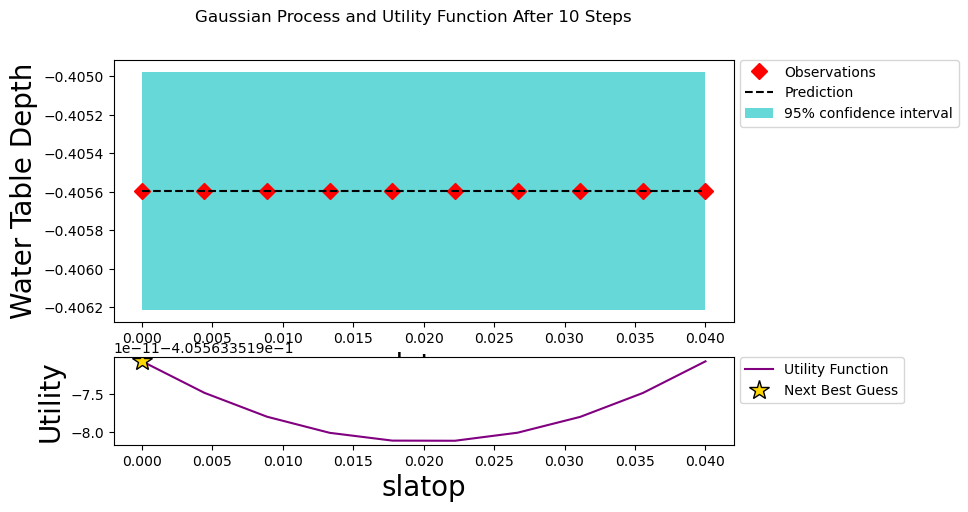

In [59]:
plot_gp_adapted(clm_optimizer1D, np.linspace(0, 0.04, 10).reshape(-1, 1), 'slatop')

### baseflow - 1D probing with fixed values

In [30]:
#Declare optimizer
clm_optimizer1D = BayesianOptimization(f = blackbox_clm, 
                                    pbounds = {#'slatop': (0, 0.04) 
                                               #'leaflong':(0.32, 2.0),
                                               #'frootleaf':(0.015, 2.0),
                                               #'slopebeta': (-500, 500)
                                               #'fff': (0, 5)
                                               'baseflow': (0, 10e-5)
                                               #'fmax' : (0.1, 0.7)
                                    }, 
                                    random_state = 58239)

In [31]:
#Probe
for p in np.linspace(0, 10e-5, 10):
    clm_optimizer1D.probe(
        params={"baseflow": p},
        lazy=True,
    )

clm_optimizer1D.maximize(init_points = 0, n_iter = 0)

|   iter    |  target   | baseflow  |
-------------------------------------


Traceback (most recent call last):
  File "/ncar/opt/sam/sam_validate.py", line 117, in <module>
    print_shadow_info(user)
  File "/ncar/opt/sam/sam_validate.py", line 84, in print_shadow_info
    print("gecos: %s" % pw.pw_gecos)
IOError: [Errno 32] Broken pipe


| 1         | -0.4056   | 0.0       |


Traceback (most recent call last):
  File "/ncar/opt/sam/sam_validate.py", line 117, in <module>
    print_shadow_info(user)
  File "/ncar/opt/sam/sam_validate.py", line 80, in print_shadow_info
    time.localtime(time.time())),
IOError: [Errno 32] Broken pipe


| 2         | -0.4057   | 1.111e-05 |


Traceback (most recent call last):
  File "/ncar/opt/sam/sam_validate.py", line 117, in <module>
    print_shadow_info(user)
  File "/ncar/opt/sam/sam_validate.py", line 84, in print_shadow_info
    print("gecos: %s" % pw.pw_gecos)
IOError: [Errno 32] Broken pipe


| 3         | -0.406    | 2.222e-05 |


Traceback (most recent call last):
  File "/ncar/opt/sam/sam_validate.py", line 114, in <module>
    check_wallclock(db, user)
  File "/ncar/opt/sam/sam_validate.py", line 32, in check_wallclock
    print ("None")
IOError: [Errno 32] Broken pipe


| 4         | -0.4063   | 3.333e-05 |


Traceback (most recent call last):
  File "/ncar/opt/sam/sam_validate.py", line 114, in <module>
    check_wallclock(db, user)
  File "/ncar/opt/sam/sam_validate.py", line 32, in check_wallclock
    print ("None")
IOError: [Errno 32] Broken pipe


| 5         | -0.4067   | 4.444e-05 |


Traceback (most recent call last):
  File "/ncar/opt/sam/sam_validate.py", line 114, in <module>
    check_wallclock(db, user)
  File "/ncar/opt/sam/sam_validate.py", line 32, in check_wallclock
    print ("None")
IOError: [Errno 32] Broken pipe


| 6         | -0.4073   | 5.556e-05 |


Traceback (most recent call last):
  File "/ncar/opt/sam/sam_validate.py", line 117, in <module>
    print_shadow_info(user)
  File "/ncar/opt/sam/sam_validate.py", line 84, in print_shadow_info
    print("gecos: %s" % pw.pw_gecos)
IOError: [Errno 32] Broken pipe


| 7         | -0.4079   | 6.667e-05 |


Traceback (most recent call last):
  File "/ncar/opt/sam/sam_validate.py", line 117, in <module>
    print_shadow_info(user)
  File "/ncar/opt/sam/sam_validate.py", line 84, in print_shadow_info
    print("gecos: %s" % pw.pw_gecos)
IOError: [Errno 32] Broken pipe


| 8         | -0.4092   | 7.778e-05 |


Traceback (most recent call last):
  File "/ncar/opt/sam/sam_validate.py", line 114, in <module>
    check_wallclock(db, user)
  File "/ncar/opt/sam/sam_validate.py", line 32, in check_wallclock
    print ("None")
IOError: [Errno 32] Broken pipe


| 9         | -0.4097   | 8.889e-05 |


Traceback (most recent call last):
  File "/ncar/opt/sam/sam_validate.py", line 117, in <module>
    print_shadow_info(user)
  File "/ncar/opt/sam/sam_validate.py", line 84, in print_shadow_info
    print("gecos: %s" % pw.pw_gecos)
IOError: [Errno 32] Broken pipe


| 10        | -0.4101   | 0.0001    |


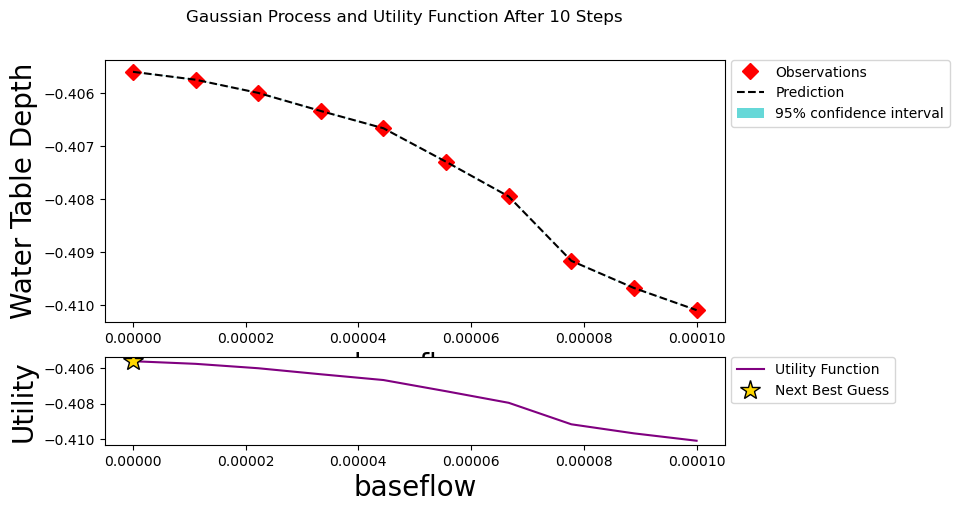

In [32]:
plot_gp_adapted(clm_optimizer1D, np.linspace(0, 10e-5, 10).reshape(-1, 1), 'baseflow')

### fmax - 1D probing with fixed values

In [34]:
#Declare optimizer
clm_optimizer1D = BayesianOptimization(f = blackbox_clm, 
                                    pbounds = {#'slatop': (0, 0.04) 
                                               #'leaflong':(0.32, 2.0),
                                               #'frootleaf':(0.015, 2.0),
                                               #'slopebeta': (-500, 500)
                                               #'fff': (0, 5)
                                               #'baseflow': (0, 10e-5)
                                               'fmax' : (0.1, 0.7)
                                    }, 
                                    random_state = 58239)

In [35]:
#Probe
for p in np.linspace(0, 0.7, 10):
    clm_optimizer1D.probe(
        params={"fmax": p},
        lazy=True,
    )

clm_optimizer1D.maximize(init_points = 0, n_iter = 0)

|   iter    |  target   |   fmax    |
-------------------------------------


Traceback (most recent call last):
  File "/ncar/opt/sam/sam_validate.py", line 117, in <module>
    print_shadow_info(user)
  File "/ncar/opt/sam/sam_validate.py", line 80, in print_shadow_info
    time.localtime(time.time())),
IOError: [Errno 32] Broken pipe


| 1         | -0.4056   | 0.0       |


Traceback (most recent call last):
  File "/ncar/opt/sam/sam_validate.py", line 114, in <module>
    check_wallclock(db, user)
  File "/ncar/opt/sam/sam_validate.py", line 32, in check_wallclock
    print ("None")
IOError: [Errno 32] Broken pipe


| 2         | -0.4056   | 0.07778   |


Traceback (most recent call last):
  File "/ncar/opt/sam/sam_validate.py", line 117, in <module>
    print_shadow_info(user)
  File "/ncar/opt/sam/sam_validate.py", line 80, in print_shadow_info
    time.localtime(time.time())),
IOError: [Errno 32] Broken pipe


| 3         | -0.4056   | 0.1556    |


Traceback (most recent call last):
  File "/ncar/opt/sam/sam_validate.py", line 114, in <module>
    check_wallclock(db, user)
  File "/ncar/opt/sam/sam_validate.py", line 32, in check_wallclock
    print ("None")
IOError: [Errno 32] Broken pipe


| 4         | -0.4056   | 0.2333    |


Traceback (most recent call last):
  File "/ncar/opt/sam/sam_validate.py", line 114, in <module>
    check_wallclock(db, user)
  File "/ncar/opt/sam/sam_validate.py", line 32, in check_wallclock
    print ("None")
IOError: [Errno 32] Broken pipe


| 5         | -0.4056   | 0.3111    |


Traceback (most recent call last):
  File "/ncar/opt/sam/sam_validate.py", line 117, in <module>
    print_shadow_info(user)
  File "/ncar/opt/sam/sam_validate.py", line 80, in print_shadow_info
    time.localtime(time.time())),
IOError: [Errno 32] Broken pipe


| 6         | -0.4056   | 0.3889    |


Traceback (most recent call last):
  File "/ncar/opt/sam/sam_validate.py", line 114, in <module>
    check_wallclock(db, user)
  File "/ncar/opt/sam/sam_validate.py", line 32, in check_wallclock
    print ("None")
IOError: [Errno 32] Broken pipe


| 7         | -0.4056   | 0.4667    |


Traceback (most recent call last):
  File "/ncar/opt/sam/sam_validate.py", line 117, in <module>
    print_shadow_info(user)
  File "/ncar/opt/sam/sam_validate.py", line 84, in print_shadow_info
    print("gecos: %s" % pw.pw_gecos)
IOError: [Errno 32] Broken pipe


| 8         | -0.4056   | 0.5444    |


Traceback (most recent call last):
  File "/ncar/opt/sam/sam_validate.py", line 114, in <module>
    check_wallclock(db, user)
  File "/ncar/opt/sam/sam_validate.py", line 32, in check_wallclock
    print ("None")
IOError: [Errno 32] Broken pipe


| 9         | -0.4056   | 0.6222    |


Traceback (most recent call last):
  File "/ncar/opt/sam/sam_validate.py", line 117, in <module>
    print_shadow_info(user)
  File "/ncar/opt/sam/sam_validate.py", line 84, in print_shadow_info
    print("gecos: %s" % pw.pw_gecos)
IOError: [Errno 32] Broken pipe


| 10        | -0.4056   | 0.7       |


In [ ]:
plot_gp_adapted(clm_optimizer1D, np.linspace(0, 0.7, 10).reshape(-1, 1), 'fmax')

### leaf_long - 1D probing with fixed values

In [53]:
#Declare optimizer
clm_optimizer1D = BayesianOptimization(f = blackbox_clm, 
                                    pbounds = {#'slatop': (0, 0.04) 
                                               'leaflong':(0.32, 2.0)
                                               #'frootleaf':(0.015, 2.0),
                                               #'slopebeta': (-500, 500)
                                               #'fff': (0, 5)
                                               #'baseflow': (0, 10e-5)
                                               #'fmax' : (0.1, 0.7)
                                    }, 
                                    random_state = 58239)

In [54]:
#Probe
for p in np.linspace(0, 2.0, 10):
    clm_optimizer1D.probe(
        params={"leaflong": p},
        lazy=True,
    )

clm_optimizer1D.maximize(init_points = 0, n_iter = 0)

|   iter    |  target   | leaflong  |
-------------------------------------


Traceback (most recent call last):
  File "/ncar/opt/sam/sam_validate.py", line 117, in <module>
    print_shadow_info(user)
  File "/ncar/opt/sam/sam_validate.py", line 80, in print_shadow_info
    time.localtime(time.time())),
IOError: [Errno 32] Broken pipe


| 1         | -0.4056   | 0.0       |


Traceback (most recent call last):
  File "/ncar/opt/sam/sam_validate.py", line 117, in <module>
    print_shadow_info(user)
  File "/ncar/opt/sam/sam_validate.py", line 80, in print_shadow_info
    time.localtime(time.time())),
IOError: [Errno 32] Broken pipe


| 2         | -0.4056   | 0.2222    |


Traceback (most recent call last):
  File "/ncar/opt/sam/sam_validate.py", line 117, in <module>
    print_shadow_info(user)
  File "/ncar/opt/sam/sam_validate.py", line 80, in print_shadow_info
    time.localtime(time.time())),
IOError: [Errno 32] Broken pipe


KeyboardInterrupt: 

In [ ]:
plot_gp_adapted(clm_optimizer1D, np.linspace(0, 2.0, 10).reshape(-1, 1), 'leaflong')